mounting drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing liberaries

In [ ]:
import numpy as np
import keras
import cv2
import os
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras import layers
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50

1- joining path by category
2- converting dataset folder to list
3-reading image
4- converting to greyscale
5- hair removal
6- image enhancement

In [ ]:
# Directory path of the data set
DATADIR = "/content/drive/MyDrive/train"
# a list of the two categories of the skin cancer
CATEGORIES = ["benign", "malignant"]
training_data = []


kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

IMG_SIZE = 224

kernel_hair = cv2.getStructuringElement(1,(17,17))

# a loop for iterating over each type of skin cancer
for category in CATEGORIES:
    # joining the path of data set with categories
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)

    # loop for iterating over the images in the benign/malignant directory
    # by converting the directory content into list
    for img in os.listdir(path):
        #reading the image by joining its benign path with name of image
        img_array = cv2.imread(os.path.join(path,img))

        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        new_array = cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB)

        # hair removal stage
        grayScale = cv2.cvtColor(new_array, cv2.COLOR_RGB2GRAY)

        blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel_hair)

        ret,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

        final_image = cv2.inpaint(new_array,threshold,1,cv2.INPAINT_TELEA)

        img_sharp = cv2.filter2D(src=final_image, ddepth=-1, kernel=kernel)
        #fixing the size of the whole images in the directory

        training_data.append([img_sharp, class_num])




In [ ]:

import random

random.shuffle(training_data)

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1 ,224 , 224, 3)
X.shape


(6670, 224, 224, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                            X, y, test_size=0.3, random_state=42)
print(len(X_train))
print(len(X_test))

4669
2001


In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

custom_early_stopping = EarlyStopping(
                                      monitor='val_loss',
                                      patience=10,
                                      restore_best_weights=True,
                                      mode= 'min'
                                  )

# Data auguments
datagen = image.ImageDataGenerator(
                                   rotation_range = 12,
                                   horizontal_flip = True,
                                   vertical_flip= True
                                   )

In [ ]:
import pickle
'''
Xtrain = open("/content/drive/MyDrive/X_train2RGB.pickle","wb")
pickle.dump(X_train, Xtrain)
Xtrain.close()
ytrain = open("/content/drive/MyDrive/y_train2RGB.pickle","wb")
pickle.dump(y_train, ytrain)
ytrain.close()
Xtest = open("/content/drive/MyDrive/X_test2RGB.pickle","wb")
pickle.dump(X_test, Xtest)
Xtest.close()
ytest = open("/content/drive/MyDrive/y_test2RGB.pickle","wb")
pickle.dump(y_test, ytest)
ytest.close()
'''


In [ ]:
import pickle


pickle_Xtrain = open("/content/drive/MyDrive/X_train2RGB.pickle","rb")
X_train = pickle.load(pickle_Xtrain)

pickle_ytrain = open("/content/drive/MyDrive/y_train2RGB.pickle","rb")
y_train = pickle.load(pickle_ytrain)

pickle_Xtest = open("/content/drive/MyDrive/X_test2RGB.pickle","rb")
X_test = pickle.load( pickle_Xtest)

pickle_ytest = open("/content/drive/MyDrive/y_test2RGB.pickle","rb")
y_test = pickle.load(pickle_ytest)



In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam


model = vgg16.VGG16(include_top=True,
                    weights=None,
                    input_tensor=None,
                    input_shape=(224,224,3),
                    pooling="max",
                    classes=2)

# Normalize pixel values to be between 0 and 1
X_train=X_train/255
X_test=X_test/255

# Converting the label data into array
y_train = np.array(y_train)
y_test = np.array(y_test)


model.compile(optimizer= Adam(learning_rate = 0.00001),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])


vgg16 = model.fit(X_train,
                        y_train, batch_size=64,
                        epochs=70,
                        validation_data=(X_test, y_test),
                        shuffle=True,verbose = 1,
                        callbacks=[learning_rate_reduction,custom_early_stopping])


Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


73/73 [==============================] - 115s 1s/step - loss: 0.5714 - accuracy: 0.7695 - val_loss: 0.5191 - val_accuracy: 0.7556 - lr: 1.0000e-05
Epoch 2/70
73/73 [==============================] - 78s 1s/step - loss: 0.4378 - accuracy: 0.7695 - val_loss: 0.4035 - val_accuracy: 0.7556 - lr: 1.0000e-05
Epoch 3/70
73/73 [==============================] - 78s 1s/step - loss: 0.3508 - accuracy: 0.8295 - val_loss: 0.3766 - val_accuracy: 0.8071 - lr: 1.0000e-05
Epoch 4/70
73/73 [==============================] - 79s 1s/step - loss: 0.2910 - accuracy: 0.8788 - val_loss: 0.2559 - val_accuracy: 0.8881 - lr: 1.0000e-05
Epoch 5/70
73/73 [==============================] - 79s 1s/step - loss: 0.2557 - accuracy: 0.8888 - val_loss: 0.2290 - val_accuracy: 0.9045 - lr: 1.0000e-05
Epoch 6/70
73/73 [==============================] - 79s 1s/step - loss: 0.2377 - accuracy: 0.8957 - val_loss: 0.2220 - val_accuracy: 0.9065 - lr: 1.0000e-05
Epoch 7/70
73/73 [==============================] - 78s 1s/step - lo

63/63 - 13s - loss: 0.1712 - accuracy: 0.9240 - 13s/epoch - 204ms/step


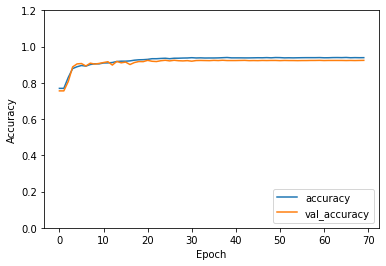

In [ ]:
plt.plot(vgg16.history['accuracy'], label='accuracy')
plt.plot(vgg16.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')


test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

63/63 - 9s - loss: 0.1712 - accuracy: 0.9240 - 9s/epoch - 150ms/step


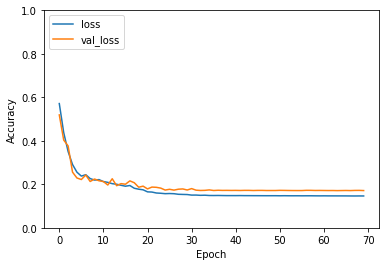

In [ ]:
plt.plot(vgg16.history['loss'], label='loss')
plt.plot(vgg16.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper left')


test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
CNN_model = Sequential()
CNN_model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu",
                        kernel_initializer="glorot_uniform",input_shape=(224,224,3)))
CNN_model.add(layers.MaxPooling2D((2,2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.5))

CNN_model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu",
                        kernel_initializer="glorot_uniform"))
CNN_model.add(BatchNormalization())
CNN_model.add(layers.MaxPooling2D((2,2)))

CNN_model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu",
                        kernel_initializer="glorot_uniform"))
CNN_model.add(layers.MaxPooling2D((2,2)))

CNN_model.add(layers.Flatten())

CNN_model.add(layers.Dense(128,activation="relu",kernel_initializer="normal"))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.5))
CNN_model.add(layers.Dense(2,activation="softmax"))




CNN_model.compile(optimizer= Adam(learning_rate = 0.0001),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

learning_CNN_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

# Normalize pixel values to be between 0 and 1
X_train=X_train/255
X_test=X_test/255

# Converting the label data into array
y_train = np.array(y_train)
y_test = np.array(y_test)

CNN = CNN_model.fit(X_train, y_train,
                       batch_size= 64, epochs= 50,
                    validation_data = (X_test, y_test),verbose = 1,
                    callbacks=[learning_CNN_reduction,custom_early_stopping])



Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


73/73 [==============================] - 22s 128ms/step - loss: 0.6690 - accuracy: 0.7186 - val_loss: 0.6189 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 2/50
73/73 [==============================] - 7s 101ms/step - loss: 0.4765 - accuracy: 0.7910 - val_loss: 0.5226 - val_accuracy: 0.8391 - lr: 1.0000e-04
Epoch 3/50
73/73 [==============================] - 7s 101ms/step - loss: 0.4373 - accuracy: 0.8218 - val_loss: 0.5162 - val_accuracy: 0.8431 - lr: 1.0000e-04
Epoch 4/50
73/73 [==============================] - 8s 106ms/step - loss: 0.3866 - accuracy: 0.8486 - val_loss: 0.4646 - val_accuracy: 0.8566 - lr: 1.0000e-04
Epoch 5/50
73/73 [==============================] - 7s 102ms/step - loss: 0.3452 - accuracy: 0.8661 - val_loss: 0.4176 - val_accuracy: 0.8686 - lr: 1.0000e-04
Epoch 6/50
73/73 [==============================] - 7s 101ms/step - loss: 0.3248 - accuracy: 0.8786 - val_loss: 0.3984 - val_accuracy: 0.8756 - lr: 1.0000e-04
Epoch 7/50
73/73 [==============================] - 7s 1

63/63 - 2s - loss: 0.3466 - accuracy: 0.8971 - 2s/epoch - 30ms/step


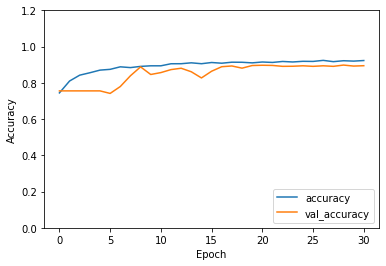

In [ ]:
plt.plot(CNN.history['accuracy'], label='accuracy')
plt.plot(CNN.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')


test_loss, test_acc = CNN_model.evaluate(X_test,  y_test, verbose=2)

63/63 - 1s - loss: 0.3466 - accuracy: 0.8971 - 1s/epoch - 20ms/step


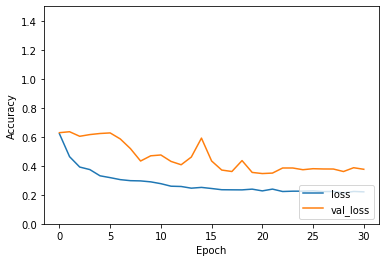

In [ ]:
plt.plot(CNN.history['loss'], label='loss')
plt.plot(CNN.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.5])
plt.legend(loc='lower right')


test_loss, test_acc = CNN_model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Define model with different applications
resnet_model = Sequential()
resnet_model.add(ResNet50(include_top=True,
                   input_tensor=None,
                   input_shape=(224,224,3),
                   pooling='max',
                   classes=2,
                   weights= None))


# Normalize pixel values to be between 0 and 1
X_train=X_train/255
X_test=X_test/255

# Converting the label da ta into array
y_train = np.array(y_train)
y_test = np.array(y_test)


resnet_model.compile(optimizer= Adam(learning_rate= 0.0001),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics
                     =['accuracy'])


learning_resnet_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

batch_size=64
epochs=50
history =  resnet_model.fit (datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs=epochs,
                              verbose=1,shuffle = True,
                              validation_data =(X_test,y_test),
                              callbacks=[learning_resnet_reduction,custom_early_stopping]
                              )


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


73/73 [==============================] - 57s 682ms/step - loss: 0.3651 - accuracy: 0.8627 - val_loss: 1.1368 - val_accuracy: 0.2444 - lr: 1.0000e-04
Epoch 2/50
73/73 [==============================] - 47s 644ms/step - loss: 0.2658 - accuracy: 0.8908 - val_loss: 0.7628 - val_accuracy: 0.2444 - lr: 1.0000e-04
Epoch 3/50
73/73 [==============================] - 47s 635ms/step - loss: 0.2785 - accuracy: 0.8861 - val_loss: 1.0262 - val_accuracy: 0.2444 - lr: 1.0000e-04
Epoch 4/50
73/73 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.8993
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
73/73 [==============================] - 47s 639ms/step - loss: 0.2560 - accuracy: 0.8993 - val_loss: 2.9338 - val_accuracy: 0.2444 - lr: 1.0000e-04
Epoch 5/50
73/73 [==============================] - 47s 635ms/step - loss: 0.2380 - accuracy: 0.8996 - val_loss: 1.2703 - val_accuracy: 0.2444 - lr: 5.0000e-05
Epoch 6/50
73/73 [==============================] - 

63/63 - 3s - loss: 0.2234 - accuracy: 0.9140 - 3s/epoch - 54ms/step


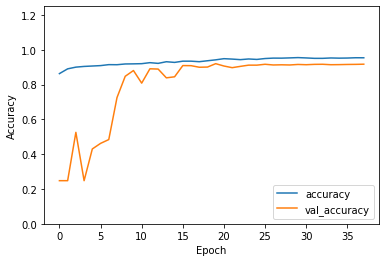

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.25])
plt.legend(loc='lower right')


test_loss, test_acc = resnet_model.evaluate(X_test,  y_test, verbose=2)

63/63 - 3s - loss: 0.2234 - accuracy: 0.9140 - 3s/epoch - 54ms/step


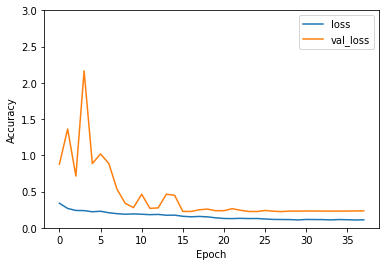

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 3])
plt.legend(loc='upper right')


test_loss, res_acc = resnet_model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
'''import os.path
if os.path.isfile('/content/drive/MyDrive/modelVGGnew.h5') is False:
   model.save('/content/drive/MyDrive/modelVGGnew.h5')'''

In [ ]:
img_array = cv2.imread('/content/10.jpg')

y = np.array(img_array).reshape(-1,224,224,3)
v = model.predict(y) #vgg model predict

In [ ]:
img_array = cv2.imread('/content/10.jpg')

y = np.array(img_array).reshape(-1,224,224,3)
c = CNN_model.predict(y) #cnn model predict
print(c)

[[1. 0.]]


In [ ]:
img_array = cv2.imread('/content/10.jpg')

y = np.array(img_array).reshape(-1,224,224,3)
r = resnet_model.predict(y) #resnet model predict

In [ ]:
'''from tensorflow.keras.models import load_model
new_vgg = load_model('/content/drive/MyDrive/modelVGGnew.h5')
new_resnet = load_model('/content/drive/MyDrive/modelRESnew.h5')
new_cnn = load_model('/content/drive/MyDrive/modelCNNnew.h5')'''

In [ ]:
'''new_c = new_cnn.evaluate(X_test,y_test)
new_v = new_vgg.evaluate(X_test,y_test)
new_res = new_resnet.evaluate(X_test,y_test)'''

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 5s 59ms/step - loss: 0.2234 - accuracy: 0.9140


In [ ]:
CNN_model.load_weight('/content/drive/MyDrive/cnn_weights.h5')

AttributeError: ignored

In [ ]:
WA = (() * 0.84) + (new_res[1] * 0.87) + (new_c[1] * 0.75))/(0.84 + 0.87 + 0.75)
print(WA)

0.7136187778740394


In [ ]:
d = {0:'benign',1:'malignant'}
if v ==